<a href="https://colab.research.google.com/github/giaschutzer/datasci266-f24-final-project/blob/main/5_aspect_based_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports & Loading Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install datasets
!pip install setfit
!pip install transformers==4.42.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.2/75.2 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.5 MB/s eta 0:00:00
     ━

In [3]:
# Data imports
import pandas as pd
import re
import nltk
nltk.download('punkt_tab')

import matplotlib.pyplot as plt
import math
import numpy as np
from nltk.tokenize import sent_tokenize

import torch
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
tqdm.pandas()

import os
os.chdir('/content/drive/MyDrive/Code + Data')
import tobit
from tobit import TobitModel

from sklearn.svm import SVR
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, ndcg_score

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [4]:
device = 0 if torch.cuda.is_available() else -1

In [ ]:
# To read original cleaned file

yelp_data = pd.read_parquet('/content/drive/MyDrive/Code + Data/yelp_data.parquet')

In [ ]:
print("5 or more helpful reviews", len(yelp_data[yelp_data['useful'] >= 5]))
yelp_data = yelp_data[yelp_data['useful'] >= 5]

In [217]:
# To read checkpointed file

yelp_data = pd.read_parquet('/content/drive/MyDrive/Code + Data/yelp_data_aspects.parquet')

In [218]:
yelp_data.columns

Index(['review_id', 'user_id', 'business_id', 'stars_reviewer', 'useful',
       'text', 'name', 'postal_code', 'stars_business', 'categories',
       'total_reviews_for_business', 'helpful', 'num_sentences',
       'aspect_counts', 'text_sent_tokenized', 'sentence_1', 'sentence_2',
       'sentence_3', 'sentence_4', 'sentence_5', 'sentence_6', 'sentence_7',
       'sentence_8', 'sentence_9', 'sentence_10', 'sentence_11', 'sentence_12',
       'sentence_1_Aspect', 'sentence_2_Aspect', 'sentence_3_Aspect',
       'sentence_4_Aspect', 'sentence_5_Aspect', 'sentence_6_Aspect',
       'sentence_7_Aspect', 'sentence_8_Aspect', 'sentence_9_Aspect',
       'sentence_10_Aspect', 'sentence_1_Aspect_FT', 'sentence_2_Aspect_FT',
       'sentence_3_Aspect_FT', 'sentence_4_Aspect_FT', 'sentence_5_Aspect_FT',
       'sentence_6_Aspect_FT', 'sentence_7_Aspect_FT', 'sentence_8_Aspect_FT',
       'sentence_9_Aspect_FT', 'sentence_10_Aspect_FT', 'concat_aspects_FT',
       'final_aspect_FT', 'aspects_sc

In [6]:
yelp_data.shape

(74071, 47)

# Feature Engineering

In [ ]:
# Tokenize text into sentences
yelp_data['text_sent_tokenized'] = yelp_data['text'].progress_apply(sent_tokenize)

100%|██████████| 74071/74071 [00:25<00:00, 2913.15it/s]
<ipython-input-134-173fd96cfda0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yelp_data['text_sent_tokenized'] = yelp_data['text'].progress_apply(sent_tokenize)


In [ ]:
# Define function to limit sequence length and pad shorter sequences with NaNs
max_sequence_length = 12
def split_sentences(row, max_sequence_length=12):
    row = row[:max_sequence_length]  # Trim the list if it has more than max_sentences
    return row + [np.nan] * (max_sequence_length - len(row))

In [ ]:
# Tokenize text into sentences
yelp_data['text_sent_tokenized'] = yelp_data['text_sent_tokenized'].progress_apply(split_sentences)

100%|██████████| 74071/74071 [00:00<00:00, 468085.48it/s]
<ipython-input-136-3d64f6e29da7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yelp_data['text_sent_tokenized'] = yelp_data['text_sent_tokenized'].progress_apply(split_sentences)


In [ ]:
# Split sentences into individual columns
aspect_data = pd.DataFrame(yelp_data['text_sent_tokenized'].tolist(), columns=[f'sentence_{i+1}' for i in range(max_sequence_length)], index=yelp_data.index)

In [ ]:
aspect_data.head()

,sentence_1,sentence_2,sentence_3,sentence_4,sentence_5,sentence_6,sentence_7,sentence_8,sentence_9,sentence_10,sentence_11,sentence_12
37,"okay, it's official: this is seriously the mos...","i visited again for breakfast, and again for d...","i visited a couple nearby brunch competitors, ...","breakfast dishes are average, and dinner dishe...","dinner visit: i had crabcakes to start, and th...",the crabcakes could not have possibly been mad...,no flavor and the texture was not good.,"not jumbo lump meat, either, which was another...",i'm a native marylander... i know crabcakes.,the chili in the frito pie was actually terrible.,i don't know how one can possibly go wrong wit...,this was not good.
53,I'm not gonna wait on this one and just start ...,"Just the right amount of food, just the right ...",I ordered the pancakes loaded with bananas and...,"Both were tasty, but bang for buck matters som...",Honey's flavor on the potatoes and crispy edge...,Just perfect.,"I'm giving 5 stars but, it's more like 4.5 bec...",Def will be here in the summer tho lol,NaN,NaN,NaN,NaN
54,Oh noooooooo....I'm so sad to have to update m...,I'm pretty stubborn about demanding a visit to...,Stopped in for an early lunch on Saturday and ...,so we were immediately seated outside.,Our server was quick to come over and asked if...,"Given the patio seating and the sunshine, I wa...",Our server recommended the seasonal caipirinha...,I'm not sure if he got the description wrong o...,"Extremely bitter, nothing sweet about it.",I had to send it back.,"Next came our large guac, still my favorite th...","The chips, however, were far more salty than I..."
64,This spot was my first introduction to Nola an...,I loved every minute of it.,"First, they take reservations.",Which is totally welcome especially for someon...,They even accommodated us when we called the e...,Great service.,"The music on the night we visited was awesome,...",I was blown away by the music they host.,The food was also delicious.,We shared an assortment of the eggplant brusch...,I would have opted for more if I wasn't so stu...,They also have an extensive and unique cocktai...
72,I visted Pat's King of Steaks after reading an...,The place is accross the steak from their comp...,Both places had long lines but because I heard...,I waited in line for 5 minutes.,I missed the crowd by fives minutes.,I was there around 1 pm.,"Once you order, It reminded me of the Soup Naz...",You have to get your cash ready (they only acc...,"If you want to take your time, don't get in line.",Then you get your cheesesteak instantly after ...,Maybe because I had high expectations but the ...,The meat was dry and over-cooked.


In [ ]:
yelp_data = yelp_data.join(aspect_data)

In [ ]:
yelp_data.shape

(74071, 27)

In [ ]:
yelp_data.columns

Index(['review_id', 'user_id', 'business_id', 'stars_reviewer', 'useful',
       'text', 'name', 'postal_code', 'stars_business', 'categories',
       'total_reviews_for_business', 'helpful', 'num_sentences',
       'aspect_counts', 'text_sent_tokenized', 'sentence_1', 'sentence_2',
       'sentence_3', 'sentence_4', 'sentence_5', 'sentence_6', 'sentence_7',
       'sentence_8', 'sentence_9', 'sentence_10', 'sentence_11',
       'sentence_12'],
      dtype='object')

In [ ]:
# Checkpoint aspect data

yelp_data.to_parquet('/content/drive/MyDrive/Code + Data/yelp_data_aspects.parquet')

# Modeling

## Part 1: Zero Shot Text Classification

In [ ]:
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=device)
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-mnli")
model = AutoModelForSequenceClassification.from_pretrained("facebook/bart-large-mnli").to("cuda")
model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

BartForSequenceClassification(
  (model): BartModel(
    (shared): BartScaledWordEmbedding(50265, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(50265, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
   

### Text Classification: Without Batching

In [ ]:
aspect_labels = (
    "Brand",
    "Ambiance",
    "Price",
    "Product / Food",
    "Convenience",
    "Service",
    "Other"
)

# Generate hypotheses based on labels
hypotheses = [f"This review is about the {label}." for label in aspect_labels]

def sentence_level_aspect(text, hypotheses=hypotheses, aspect_labels=aspect_labels, max_length=256):

  tokenized_inputs = [
      tokenizer(
          text,
          hypothesis,
          padding=True,
          truncation=True,
          max_length=max_length,
          return_tensors="pt"
      ).to("cuda")
      for hypothesis in hypotheses
  ]

  # Perform inference for each hypothesis
  with torch.no_grad():
      logits = [model(**inputs).logits for inputs in tokenized_inputs]

  entailment_scores = torch.stack([logit[:, 2] for logit in logits]).squeeze()

  # Find the label with the highest entailment score
  predicted_index = torch.argmax(entailment_scores).item()
  predicted_label = aspect_labels[predicted_index]

  return predicted_label

In [7]:
sentences = yelp_data[[
    'sentence_1', 'sentence_2', 'sentence_3', 'sentence_4',
    'sentence_5', 'sentence_6', 'sentence_7', 'sentence_8',
    'sentence_9', 'sentence_10','sentence_11', 'sentence_12'
]]

In [ ]:
test_sent = sentences.iloc[10]
for sent in test_sent:
  print(f"{sent}, Category: {sentence_level_aspect(sent)}")

This is the perfect COVID adventure., Category: Other
This historic drive-in was on the show Diners, Drive-Ins and Dives on the Food Network and is a great local spot to get affordable food without leaving your car., Category: Product / Food
While the actual drive-in PA system is out of order currently, there is a drive-thru window around the back that you can always pull up to., Category: Other
Once you pull up, ring the doorbell on the window so the staff know you're there., Category: Convenience
Speaking of the staff, they were SO fun and jolly., Category: Service
It felt so unexpected to have someone in such amazing spirits greet us at the window., Category: Other
I loved it., Category: Product / Food
We ordered our food, were told to park a few feet away, and then they brought our food out to us within ten minutes., Category: Service
I got the Twin Steer Sandwich which is essentially a layered burger (there's a bun within the burger!), Category: Product / Food
and was delicious., 

### Text Classification: Batching

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-mnli")
model = AutoModelForSequenceClassification.from_pretrained("facebook/bart-large-mnli").to("cuda")
model.eval()  # Set model to evaluation mode

# Aspect labels and hypotheses
aspect_labels = [
    "Brand",
    "Ambiance",
    "Price",
    "Product / Food",
    "Convenience",
    "Service",
    "Other"
]

hypotheses = [f"This review is about the {label}." for label in aspect_labels]

def batch_sentence_level_aspect(texts, hypotheses=hypotheses, aspect_labels=aspect_labels, max_length=256, batch_size=512):
    """
    Function to classify a batch of texts into one of the pre-determined categories.
    """
    all_predictions = []

    num_batches = (len(texts) + batch_size - 1) // batch_size  # Calculate the number of batches

    for batch_start in range(0, len(texts), batch_size):
        batch_end = min(batch_start + batch_size, len(texts))
        batch_texts = texts[batch_start:batch_end]

        # Filter out NA values
        non_na_indices = [i for i, text in enumerate(batch_texts) if pd.notna(text)]
        non_na_texts = [text for i, text in enumerate(batch_texts) if i in non_na_indices]

        if not non_na_texts:  # If all texts in the batch are NA, skip this batch
            all_predictions.extend([None] * len(batch_texts))
            continue

        # Tokenize inputs for each hypothesis in the batch
        tokenized_inputs = [
            tokenizer(
                non_na_texts,
                [hypothesis] * len(non_na_texts),
                padding=True,
                truncation=True,
                max_length=max_length,
                return_tensors="pt"
            ).to("cuda")
            for hypothesis in hypotheses
        ]

        # Perform inference for each hypothesis
        with torch.no_grad():
            logits = [model(**inputs).logits for inputs in tokenized_inputs]

        # Stack entailment scores for all hypotheses
        entailment_scores = torch.stack([logit[:, 2] for logit in logits], dim=1)

        # Find the label with the highest entailment score for each text in the batch
        predicted_indices = torch.argmax(entailment_scores, dim=1).cpu().numpy()
        predicted_labels = [aspect_labels[i] for i in predicted_indices]

        # Insert predictions back into their original positions
        predictions = [None] * len(batch_texts)
        for idx, pred in zip(non_na_indices, predicted_labels):
            predictions[idx] = pred

        all_predictions.extend(predictions)

    return all_predictions

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

In [ ]:
# Process each column and store results in a new column using progress_apply
for column in sentences.columns[2:]:
    # Apply function to column
    print(f"Processing column: {column}")
    yelp_data[f"{column}_Aspect"] = yelp_data[column].progress_apply(lambda x: batch_sentence_level_aspect([x])[0])

    # Checkpoint data
    yelp_data.to_parquet('/content/drive/MyDrive/Code + Data/yelp_data_aspects.parquet')

Processing column: sentence_3


100%|██████████| 74071/74071 [2:49:47<00:00,  7.27it/s]


Processing column: sentence_4


100%|██████████| 74071/74071 [2:45:36<00:00,  7.45it/s]


Processing column: sentence_5


100%|██████████| 74071/74071 [2:39:51<00:00,  7.72it/s]


Processing column: sentence_6


100%|██████████| 74071/74071 [2:34:34<00:00,  7.99it/s]


Processing column: sentence_7


100%|██████████| 74071/74071 [2:24:28<00:00,  8.54it/s]


Processing column: sentence_8


100%|██████████| 74071/74071 [2:14:56<00:00,  9.15it/s]


Processing column: sentence_9


100%|██████████| 74071/74071 [2:05:53<00:00,  9.81it/s]


Processing column: sentence_10


100%|██████████| 74071/74071 [1:56:42<00:00, 10.58it/s]


Processing column: sentence_11


  0%|          | 160/74071 [00:14<1:40:34, 12.25it/s]

In [ ]:
# Check final columns

yelp_data.columns

Index(['review_id', 'user_id', 'business_id', 'stars_reviewer', 'useful',
       'text', 'name', 'postal_code', 'stars_business', 'categories',
       'total_reviews_for_business', 'helpful', 'num_sentences',
       'aspect_counts', 'text_sent_tokenized', 'sentence_1', 'sentence_2',
       'sentence_3', 'sentence_4', 'sentence_5', 'sentence_6', 'sentence_7',
       'sentence_8', 'sentence_9', 'sentence_10', 'sentence_11', 'sentence_12',
       'sentence_1_Aspect', 'sentence_2_Aspect', 'sentence_3_Aspect',
       'sentence_4_Aspect', 'sentence_5_Aspect', 'sentence_6_Aspect',
       'sentence_7_Aspect', 'sentence_8_Aspect', 'sentence_9_Aspect',
       'sentence_10_Aspect'],
      dtype='object')

In [ ]:
# Print value counts per column

for column in sentences.columns[:-2]:
    print(f"Value counts for column: {column}")
    print(yelp_data[f"{column}_Aspect"].value_counts())
    print("Null values", yelp_data[f"{column}_Aspect"].isna().sum())
    print("--------------------")

Value counts for column: sentence_1
sentence_1_Aspect
Other             36038
Product / Food    23237
Brand              3914
Ambiance           3381
Service            3379
Convenience        3288
Price               834
Name: count, dtype: int64
Null values 0
--------------------
Value counts for column: sentence_2
sentence_2_Aspect
Other             35052
Product / Food    21220
Service            5215
Convenience        4300
Ambiance           4103
Brand              2753
Price              1141
Name: count, dtype: int64
Null values 287
--------------------
Value counts for column: sentence_3
sentence_3_Aspect
Other             33345
Product / Food    22348
Service            5967
Convenience        4397
Ambiance           3826
Brand              1937
Price              1276
Name: count, dtype: int64
Null values 975
--------------------
Value counts for column: sentence_4
sentence_4_Aspect
Other             31787
Product / Food    23309
Service            6090
Convenience        41

In [139]:
# Concatenate aspect columns

aspect_columns = yelp_data[[
    "sentence_1_Aspect", "sentence_2_Aspect", "sentence_3_Aspect",
    "sentence_4_Aspect", "sentence_5_Aspect", "sentence_6_Aspect",
    "sentence_7_Aspect", "sentence_8_Aspect", "sentence_9_Aspect",
    "sentence_10_Aspect"
]]

yelp_data['concat_aspects_ZS'] = aspect_columns.values.tolist()
yelp_data['concat_aspects_ZS'] = yelp_data['concat_aspects_ZS'].apply(lambda x: list(filter(None, x)))

In [140]:
# Function to define majority aspect

def majority_word(words):
    word_counts = {}
    total_count = len(words)

    for word in words:
        if word in word_counts:
            word_counts[word] += 1
        else:
            word_counts[word] = 1

    for word, count in word_counts.items():
        if count > total_count // 2:
            return word

    return "Multiple"

In [141]:
# Classify final aspects

yelp_data['final_aspect_ZS'] = yelp_data['concat_aspects_ZS'].apply(majority_word)

In [142]:
# Check value counts of final aspects

yelp_data['final_aspect_ZS'].value_counts()

,count
final_aspect_ZS,
Multiple,31427
Other,24118
Product / Food,17953
Service,288
Convenience,159
Ambiance,75
Price,34
Brand,17


## Part 2: Helpfulness Prediction

### Model 1: Zero-Shot SVM

In [ ]:
yelp_data['helpful'] = yelp_data['helpful'].apply(lambda x: x * 100)

In [123]:
# Set X and Y variables
X = yelp_data['final_aspect']
Y = yelp_data['helpful']

In [124]:
# One-hot encode aspects
X_one_hot = pd.get_dummies(X)

In [125]:
# Split data into training, validation, and testing

X_train_val, X_test, Y_train_val, Y_test = train_test_split(X_one_hot, Y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.25, random_state=42)

In [126]:
# Build layer 2 regression

# create an SVR model with a linear kernel
svr = SVR(kernel='rbf')

# train the model on the data
model_1 = svr.fit(X_train, Y_train)

# make predictions on the data
y_pred_1 = svr.predict(X_val)

In [127]:
# Report errors
aspect_mse_1 = mean_squared_error(Y_val, y_pred_1)
aspect_rmse_1 = math.sqrt(aspect_mse_1)
aspect_mae_1 =  mean_absolute_error(Y_val, y_pred_1)

print(f'MSE: {aspect_mse_1}')
print(f'RMSE: {aspect_rmse_1}')
print(f'MAE: {aspect_mae_1}')

# Print estimated coefficients
for coef in X_one_hot.columns[:-1]:
  print(f'Coefficient (for {coef}): {model_1._dual_coef_[0][X_one_hot.columns.get_loc(coef)]}')
print("Intercept:", model_1.intercept_)

MSE: 1.9686280562741734
RMSE: 1.4030780649251748
MAE: 0.7344711325238052
Coefficient (for Ambiance): 1.0
Coefficient (for Brand): 1.0
Coefficient (for Convenience): 1.0
Coefficient (for Multiple): 1.0
Coefficient (for Other): 1.0
Coefficient (for Price): 1.0
Coefficient (for Product / Food): 1.0
Intercept: [0.84785608]


In [128]:
true_helpful = np.asarray([Y_val])
pred_helpful = np.asarray([y_pred_1])
model_1_ndcg_5 = ndcg_score(true_helpful, pred_helpful, k=5)
model_1_ndcg_25 = ndcg_score(true_helpful, pred_helpful, k=25)
model_1_ndcg_50 = ndcg_score(true_helpful, pred_helpful, k=50)
model_1_ndcg_100 = ndcg_score(true_helpful, pred_helpful, k=100)
model_1_ndcg_1000 = ndcg_score(true_helpful, pred_helpful, k=1000)
model_1_ndcg_all = ndcg_score(true_helpful, pred_helpful)


# Print nDCG scores for each k value
print(f'NDCG Score for k=5: {model_1_ndcg_5}')
print(f'NDCG Score for k=25: {model_1_ndcg_25}')
print(f'NDCG Score for k=50: {model_1_ndcg_50}')
print(f'NDCG Score for k=100: {model_1_ndcg_100}')
print(f'NDCG Score for k=1000: {model_1_ndcg_1000}')
print(f'NDCG Score for all: {model_1_ndcg_all}')

NDCG Score for k=5: 0.04949141805065431
NDCG Score for k=25: 0.06657487083552727
NDCG Score for k=50: 0.07929815973385401
NDCG Score for k=100: 0.09830525654020517
NDCG Score for k=1000: 0.23229373477395396
NDCG Score for all: 0.828336537397362


### Model 2: Few Shot SVM

#### Step 1: Train model using ~200 rows of hand-labeled data

In [30]:
# Save out file for hand labeling
yelp_data[:50].to_csv("/content/drive/MyDrive/Code + Data/yelp_data_aspects_hand_label.csv")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
from setfit import SetFitModel, Trainer, TrainingArguments, sample_dataset
from transformers import AutoTokenizer

In [9]:
hand_labeled_data = pd.read_csv("/content/drive/MyDrive/Code + Data/yelp_data_aspects_hand_label.csv")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
hand_labeled_data = hand_labeled_data[['sentence', 'final_label']]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
hand_labeled_data['final_label'].value_counts()

,count
final_label,
Other,64
Product / Food,43
Service,42
Ambiance / Environment,41
Contextual Information,37
Brand,21
Price,18


In [12]:
# Sample 10 rows per label from dataset
sample_size = 10
train_hl = hand_labeled_data.groupby('final_label').sample(n=sample_size, random_state=42)

In [13]:
# Create a boolean mask
mask = ~hand_labeled_data['sentence'].isin(train_hl['sentence'])

# Drop rows from training set
hand_labeled_data = hand_labeled_data[mask]

In [14]:
# Split rest of data into validation and testing
val_hl, test_hl = train_test_split(hand_labeled_data, test_size=0.5, random_state=42)

# Convert to dataset (expected input format)
from datasets import Dataset, DatasetDict
train_ds = Dataset.from_pandas(train_hl)
val_ds = Dataset.from_pandas(val_hl)
test_ds = Dataset.from_pandas(test_hl)

ds = DatasetDict()
ds['train'] = train_ds
ds['val'] = val_ds
ds['test'] = test_ds

In [15]:
# Load sentence transformers from HuggingFace

hf_pretained_model = "sentence-transformers/paraphrase-mpnet-base-v2"
labels = [
    "Brand",
    "Ambiance / Environment",
    "Price",
    "Product / Food",
    "Service",
    "Contextual Information",
    "Other"
]

model = SetFitModel.from_pretrained(
    hf_pretained_model,
    labels=labels
    ).to(device=device)


# Set training arguments
training_args = TrainingArguments(
    batch_size=32,
    num_epochs=1)

# Create trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    metric='accuracy',
    column_mapping={"sentence": "text", "final_label": "label"}
)

# Train
trainer.train()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/594 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to the training dataset
Applying column mapping to the evaluation dataset


Map:   0%|          | 0/70 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 4200
  Batch size = 32
  Num epochs = 1
/usr/local/lib/python3.10/dist-packages/notebook/utils.py:280: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  return LooseVersion(v) >= LooseVersion(check)
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss
1,0.204400
50,0.160100
100,0.031400


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

In [16]:
# Evaluate
metrics = trainer.evaluate(test_ds)
print("Test accuracy", metrics['accuracy'])

Applying column mapping to the evaluation dataset
***** Running evaluation *****


Test accuracy 0.7040816326530612


In [17]:
# Save the finetuned model locally
model.save_pretrained('aspects_finetuned')
finetuned_model = SetFitModel.from_pretrained('aspects_finetuned')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
predictions = []
for sentence in test_ds['sentence']:
  predictions.append(finetuned_model.predict(sentence))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


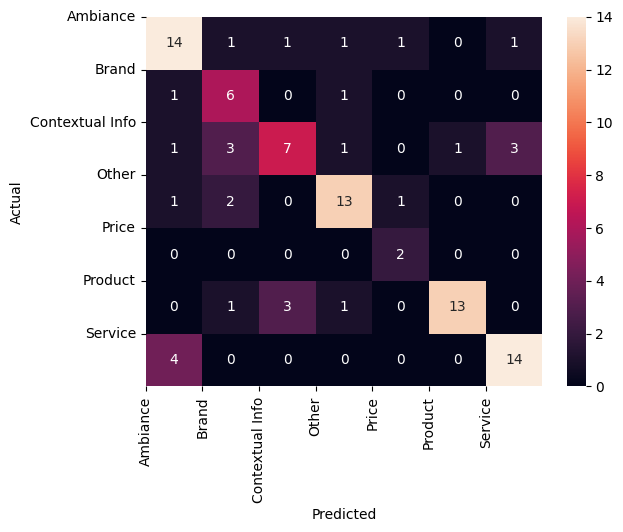

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_ds['final_label'], predictions)
cm_labels = sorted(["Brand",
            "Ambiance",
            "Price",
            "Product",
            "Service",
            "Contextual Info",
            "Other"
        ])

sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0, 1, 2, 3, 4, 5, 6],
            cm_labels)
plt.xticks(rotation=90)
plt.yticks([0, 1, 2, 3, 4, 5, 6],
           cm_labels)
plt.yticks(rotation=360)
plt.show()

In [21]:
# Test finetuned_model

for sentence in sentences.iloc[500]:
  print(f"{sentence} \n Prediction: {finetuned_model.predict(sentence)}")
  print("----")

Wright's is one of those seriously Oh-My-God awesome places that you MUST try if you live in Tampa. 
 Prediction: Brand
----
Yes, I know.....it's located south of Kennedy Boulevard on South Dale Mabry, but you'll just need to suck it up and go there. 
 Prediction: Brand
----
You can thank me later. 
 Prediction: Other
----
Wright's was started in 1963 as a small gourmet shop with imported and domestic delicacies, fresh coffees, teas, and spices. 
 Prediction: Brand
----
The husband and wife team gradually moved into making sandwiches, fresh salads, and AMAZING desserts, and that's how we got the Wright's which we all know and love. 
 Prediction: Brand
----
The business is now owned and operated by the grandson of original owners, and the family recipes have been passed down through the generations. 
 Prediction: Brand
----
Today Wright's is a deli, a bakery, a cafe', and a huge catering business. 
 Prediction: Brand
----
In the morning, they are busy cranking out breakfast sandwiches a

#### Step 2: Use few-shot model to classify aspect in dataset

In [25]:
# Process each column and store results in a new column using progress_apply
for column in sentences.columns[1:-2]:
    # Apply function to column
    print(f"Processing column: {column}")
    yelp_data[f"{column}_Aspect_FT"] = yelp_data[column].progress_apply(lambda x: finetuned_model.predict(x) if x is not None else None)

    # Checkpoint data
    yelp_data.to_parquet('/content/drive/MyDrive/Code + Data/yelp_data_aspects.parquet')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Processing column: sentence_2


100%|██████████| 74071/74071 [16:47<00:00, 73.55it/s]


Processing column: sentence_3


100%|██████████| 74071/74071 [17:12<00:00, 71.74it/s]


Processing column: sentence_4


100%|██████████| 74071/74071 [17:00<00:00, 72.60it/s]


Processing column: sentence_5


100%|██████████| 74071/74071 [16:13<00:00, 76.12it/s]


Processing column: sentence_6


100%|██████████| 74071/74071 [15:06<00:00, 81.71it/s]


Processing column: sentence_7


100%|██████████| 74071/74071 [14:12<00:00, 86.85it/s]


Processing column: sentence_8


100%|██████████| 74071/74071 [13:20<00:00, 92.55it/s]


Processing column: sentence_9


100%|██████████| 74071/74071 [12:28<00:00, 98.92it/s]


Processing column: sentence_10


100%|██████████| 74071/74071 [11:25<00:00, 108.12it/s]


#### Step 3: Calculate final aspect

In [164]:
yelp_data = pd.read_parquet('/content/drive/MyDrive/Code + Data/yelp_data_aspects.parquet')

In [169]:
yelp_data.columns

Index(['review_id', 'user_id', 'business_id', 'stars_reviewer', 'useful',
       'text', 'name', 'postal_code', 'stars_business', 'categories',
       'total_reviews_for_business', 'helpful', 'num_sentences',
       'aspect_counts', 'text_sent_tokenized', 'sentence_1', 'sentence_2',
       'sentence_3', 'sentence_4', 'sentence_5', 'sentence_6', 'sentence_7',
       'sentence_8', 'sentence_9', 'sentence_10', 'sentence_11', 'sentence_12',
       'sentence_1_Aspect', 'sentence_2_Aspect', 'sentence_3_Aspect',
       'sentence_4_Aspect', 'sentence_5_Aspect', 'sentence_6_Aspect',
       'sentence_7_Aspect', 'sentence_8_Aspect', 'sentence_9_Aspect',
       'sentence_10_Aspect', 'sentence_1_Aspect_FT', 'sentence_2_Aspect_FT',
       'sentence_3_Aspect_FT', 'sentence_4_Aspect_FT', 'sentence_5_Aspect_FT',
       'sentence_6_Aspect_FT', 'sentence_7_Aspect_FT', 'sentence_8_Aspect_FT',
       'sentence_9_Aspect_FT', 'sentence_10_Aspect_FT', 'concat_aspects_FS'],
      dtype='object')

In [166]:
# Concatenate aspect columns

aspect_columns_FS = yelp_data[[
    "sentence_1_Aspect_FT", "sentence_2_Aspect_FT", "sentence_3_Aspect_FT",
    "sentence_4_Aspect_FT", "sentence_5_Aspect_FT", "sentence_6_Aspect_FT",
    "sentence_7_Aspect_FT", "sentence_8_Aspect_FT", "sentence_9_Aspect_FT",
    "sentence_10_Aspect_FT"
]]

yelp_data['concat_aspects_FS'] = aspect_columns_FS.values.tolist()
yelp_data['concat_aspects_FS'] = yelp_data['concat_aspects_FS'].apply(lambda x: list(filter(None, x)))

In [170]:
yelp_data['final_aspect_FS'] = yelp_data['concat_aspects_FS'].apply(majority_word)

In [171]:
yelp_data['final_aspect_FS'].value_counts()

,count
final_aspect_FS,
Multiple,55602
Product / Food,9744
Ambiance / Environment,4003
Service,1855
Other,1267
Contextual Information,709
Price,461
Brand,430


 #### Step 4: Run SVM regression

In [47]:
yelp_data['helpful'] = yelp_data['helpful'].apply(lambda x: x * 100)

In [50]:
# Set X and Y variables
X = yelp_data['final_aspect_FS']
Y = yelp_data['helpful']

In [51]:
# One-hot encode aspects
X_one_hot = pd.get_dummies(X)
X_one_hot.columns = X_one_hot.columns.astype(str)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [52]:
# Split data into training, validation, and testing

X_train_val, X_test, Y_train_val, Y_test = train_test_split(X_one_hot, Y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.25, random_state=42)

In [53]:
# Build layer 2 regression

# create an SVR model with a linear kernel
svr = SVR(kernel='rbf')

# train the model on the data
model_2 = svr.fit(X_train, Y_train)

# make predictions on the data
y_pred_2 = svr.predict(X_val)

In [58]:
# Report errors
aspect_mse_2 = mean_squared_error(Y_val, y_pred_2)
aspect_rmse_2 = math.sqrt(aspect_mse_2)
aspect_mae_2 =  mean_absolute_error(Y_val, y_pred_2)

print(f'MSE: {aspect_mse_2}')
print(f'RMSE: {aspect_rmse_2}')
print(f'MAE: {aspect_mae_2}')

# Print estimated coefficients
for coef in X_one_hot.columns[:-1]:
  print(f'Coefficient (for {coef}): {model_2._dual_coef_[0][X_one_hot.columns.get_loc(coef)]}')
print("Intercept:", model_2.intercept_)

MSE: 1.9693188142385039
RMSE: 1.403324201401267
MAE: 0.7349013715638931
Coefficient (for Ambiance / Environment): 1.0
Coefficient (for Brand): 1.0
Coefficient (for Contextual Information): 1.0
Coefficient (for Multiple): -1.0
Coefficient (for Other): 1.0
Coefficient (for Price): 1.0
Coefficient (for Product / Food): 1.0
Intercept: [0.88348233]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [56]:
true_helpful = np.asarray([Y_val])
pred_helpful = np.asarray([y_pred_2])
model_1_ndcg_5 = ndcg_score(true_helpful, pred_helpful, k=5)
model_1_ndcg_25 = ndcg_score(true_helpful, pred_helpful, k=25)
model_1_ndcg_50 = ndcg_score(true_helpful, pred_helpful, k=50)
model_1_ndcg_100 = ndcg_score(true_helpful, pred_helpful, k=100)
model_1_ndcg_1000 = ndcg_score(true_helpful, pred_helpful, k=1000)
model_1_ndcg_all = ndcg_score(true_helpful, pred_helpful)

# Print nDCG scores for each k value
print(f'NDCG Score for k=5: {model_1_ndcg_5}')
print(f'NDCG Score for k=25: {model_1_ndcg_25}')
print(f'NDCG Score for k=50: {model_1_ndcg_50}')
print(f'NDCG Score for k=100: {model_1_ndcg_100}')
print(f'NDCG Score for k=1000: {model_1_ndcg_1000}')
print(f'NDCG Score for all: {model_1_ndcg_all}')

NDCG Score for k=5: 0.048672813271928274
NDCG Score for k=25: 0.06547369997488932
NDCG Score for k=50: 0.0779865413753767
NDCG Score for k=100: 0.0966792543776618
NDCG Score for k=1000: 0.22845151790396143
NDCG Score for all: 0.8263894517292973


### Model 3: Few-Shot SVM Regression w/o Majority Aspect Approach

#### Step 1: Calculate % of times aspect appears

In [221]:
yelp_data.columns

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['review_id', 'user_id', 'business_id', 'stars_reviewer', 'useful',
       'text', 'name', 'postal_code', 'stars_business', 'categories',
       'total_reviews_for_business', 'helpful', 'num_sentences',
       'aspect_counts', 'text_sent_tokenized', 'sentence_1', 'sentence_2',
       'sentence_3', 'sentence_4', 'sentence_5', 'sentence_6', 'sentence_7',
       'sentence_8', 'sentence_9', 'sentence_10', 'sentence_11', 'sentence_12',
       'sentence_1_Aspect', 'sentence_2_Aspect', 'sentence_3_Aspect',
       'sentence_4_Aspect', 'sentence_5_Aspect', 'sentence_6_Aspect',
       'sentence_7_Aspect', 'sentence_8_Aspect', 'sentence_9_Aspect',
       'sentence_10_Aspect', 'sentence_1_Aspect_FT', 'sentence_2_Aspect_FT',
       'sentence_3_Aspect_FT', 'sentence_4_Aspect_FT', 'sentence_5_Aspect_FT',
       'sentence_6_Aspect_FT', 'sentence_7_Aspect_FT', 'sentence_8_Aspect_FT',
       'sentence_9_Aspect_FT', 'sentence_10_Aspect_FT', 'concat_aspects_FT',
       'final_aspect_FT', 'aspects_sc

In [222]:
from collections import Counter
yelp_data['aspects_score_FS'] = yelp_data['concat_aspects_FT'].apply(lambda x: Counter(x))

In [223]:
aspect_scores = pd.json_normalize(yelp_data['aspects_score_FS'])
aspect_scores.fillna(0, inplace=True)

In [225]:
yelp_data.drop([
    'Brand', 'Contextual Information',
    'Product / Food', 'Price', 'Other',
    'Ambiance / Environment','Service'
], axis=1, inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [226]:
# Reset index to create a temporary index for joining
yelp_data = yelp_data.reset_index()

In [227]:
yelp_data = yelp_data.merge(aspect_scores, left_index=True, right_index=True)

In [228]:
yelp_data.index = yelp_data['index']
yelp_data = yelp_data.drop('index', axis=1)

In [230]:
# Calculate the sum of the selected columns
num_sent = yelp_data['concat_aspects_FT'].str.len()

# Divide aspect counts by number of sentences
yelp_data[aspect_scores.columns] = yelp_data[aspect_scores.columns].div(num_sent,axis=0)

In [231]:
yelp_data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,level_0,review_id,user_id,business_id,stars_reviewer,useful,text,name,postal_code,stars_business,...,final_aspect_FT,aspects_score,aspects_score_FS,Brand,Contextual Information,Product / Food,Price,Other,Ambiance / Environment,Service
index,,,,,,,,,,,,,,,,,,,,,
37,0,4S7XqQSLtVsBV1OXwi6EQQ,i7zuRDllj1KTqoSHUayV_w,cXSyVvOr9YRN9diDkaWs0Q,2,5,"okay, it's official: this is seriously the mos...",Honey's Sit-N-Eat,19123,4.0,...,Product / Food,"{'Ambiance / Environment': None, 'Brand': 2.0,...","{'Brand': 2, 'Contextual Information': 1, 'Pro...",0.2,0.100,0.700,0.00,0.000,0.000,0.0
53,1,t8dHlEE8sgX73q6G7AwiRQ,BmVwbsL8l0imz4slonyMaA,bN_9QgxdOIk4oK-6fBDJtQ,4,52,I'm not gonna wait on this one and just start ...,Honey's Sit N Eat,19146,4.0,...,Multiple,"{'Ambiance / Environment': 1.0, 'Brand': None,...","{'Product / Food': 3, 'Price': 2, 'Other': 1, ...",0.0,0.125,0.375,0.25,0.125,0.125,0.0
54,2,KfBygsBklyLQsYS7qrgqIQ,WhqG_9cfE6HM9Z_ts81xBA,4szMVHmGXodrVGw4Zhev9g,3,6,Oh noooooooo....I'm so sad to have to update m...,Bartaco,37204,4.5,...,Multiple,"{'Ambiance / Environment': 1.0, 'Brand': 3.0, ...","{'Brand': 3, 'Contextual Information': 1, 'Ser...",0.3,0.100,0.200,0.00,0.100,0.100,0.2
64,3,ltfA3rNpUxMLU7ULxU77Zw,3qcwwtzktfHqWpPcNvUvYA,jMZ56S8Y1t7cA1Ob-d-qeA,4,5,This spot was my first introduction to Nola an...,Three Muses,70116,4.0,...,Multiple,"{'Ambiance / Environment': 3.0, 'Brand': None,...","{'Contextual Information': 2, 'Other': 1, 'Ser...",0.0,0.200,0.200,0.00,0.100,0.300,0.2
72,4,X284NGU-p78bHCSsMcfR1g,F1uO9Vlwcpfp1FPSANVRJg,PP3BBaVxZLcJU54uP_wL6Q,2,8,I visted Pat's King of Steaks after reading an...,Pat's King of Steaks,19147,3.0,...,Multiple,"{'Ambiance / Environment': None, 'Brand': 3.0,...","{'Brand': 3, 'Service': 4, 'Other': 1, 'Contex...",0.3,0.100,0.000,0.10,0.100,0.000,0.4


#### Step 2: Run SVM regression

In [232]:
# Set X and Y variables
X = yelp_data[aspect_scores.columns]
Y = yelp_data['helpful']

In [233]:
# Split data into training, validation, and testing

X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.25, random_state=42)

In [234]:
# Build layer 2 regression

# create an SVR model with a linear kernel
svr = SVR(kernel='rbf')

# train the model on the data
model_3 = svr.fit(X_train, Y_train)

# make predictions on the data
y_pred_3 = svr.predict(X_val)

In [235]:
# Report errors
aspect_mse_3 = mean_squared_error(Y_val, y_pred_3)
aspect_rmse_3 = math.sqrt(aspect_mse_3)
aspect_mae_3 =  mean_absolute_error(Y_val, y_pred_3)

print(f'MSE: {aspect_mse_3}')
print(f'RMSE: {aspect_rmse_3}')
print(f'MAE: {aspect_mae_3}')

# Print estimated coefficients
for coef in X.columns[:-1]:
  print(f'Coefficient (for {coef}): {model_3._dual_coef_[0][X.columns.get_loc(coef)]}')
print("Intercept:", model_3.intercept_)

MSE: 1.9572393031730855
RMSE: 1.399013689415899
MAE: 0.7306568561594082
Coefficient (for Brand): 1.0
Coefficient (for Contextual Information): 1.0
Coefficient (for Product / Food): 1.0
Coefficient (for Price): -1.0
Coefficient (for Other): 1.0
Coefficient (for Ambiance / Environment): 1.0
Intercept: [0.36977068]


In [239]:
true_helpful = np.asarray([Y_val])
pred_helpful = np.asarray([y_pred_3])
model_3_ndcg_5 = ndcg_score(true_helpful, pred_helpful, k=5)
model_3_ndcg_25 = ndcg_score(true_helpful, pred_helpful, k=25)
model_3_ndcg_50 = ndcg_score(true_helpful, pred_helpful, k=50)
model_3_ndcg_100 = ndcg_score(true_helpful, pred_helpful, k=100)
model_3_ndcg_1000 = ndcg_score(true_helpful, pred_helpful, k=1000)
model_3_ndcg_all = ndcg_score(true_helpful, pred_helpful)

# Print nDCG scores for each k value
print(f'NDCG Score for k=5: {model_3_ndcg_5}')
print(f'NDCG Score for k=25: {model_3_ndcg_25}')
print(f'NDCG Score for k=50: {model_3_ndcg_50}')
print(f'NDCG Score for k=100: {model_3_ndcg_100}')
print(f'NDCG Score for k=1000: {model_3_ndcg_1000}')
print(f'NDCG Score for all: {model_3_ndcg_all}')

NDCG Score for k=5: 0.0406891741600613
NDCG Score for k=25: 0.07801320114818808
NDCG Score for k=50: 0.08701014075981381
NDCG Score for k=100: 0.11010709196251406
NDCG Score for k=1000: 0.24348658398494563
NDCG Score for all: 0.8308572477378615


In [247]:
ndcg_scores = pd.DataFrame(
   [model_3_ndcg_5,
    model_3_ndcg_25,
    model_3_ndcg_50,
    model_3_ndcg_100,
    model_3_ndcg_1000,
    model_3_ndcg_all,]
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [249]:
ndcg_scores.to_csv('/content/drive/MyDrive/Code + Data/Final NDCG Scores/aspect_ndcg_scores.csv')

### Model 4: No-Shot SVM Regression w/o Majority Aspect Approach

In [138]:
yelp_data.columns

Index(['review_id', 'user_id', 'business_id', 'stars_reviewer', 'useful',
       'text', 'name', 'postal_code', 'stars_business', 'categories',
       'total_reviews_for_business', 'helpful', 'num_sentences',
       'aspect_counts', 'text_sent_tokenized', 'sentence_1', 'sentence_2',
       'sentence_3', 'sentence_4', 'sentence_5', 'sentence_6', 'sentence_7',
       'sentence_8', 'sentence_9', 'sentence_10', 'sentence_11', 'sentence_12',
       'sentence_1_Aspect', 'sentence_2_Aspect', 'sentence_3_Aspect',
       'sentence_4_Aspect', 'sentence_5_Aspect', 'sentence_6_Aspect',
       'sentence_7_Aspect', 'sentence_8_Aspect', 'sentence_9_Aspect',
       'sentence_10_Aspect'],
      dtype='object')

In [143]:
yelp_data['aspects_score_ZS'] = yelp_data['concat_aspects_ZS'].apply(lambda x: Counter(x))

In [144]:
aspect_scores = pd.json_normalize(yelp_data['aspects_score_ZS'])
aspect_scores.fillna(0, inplace=True)

In [145]:
# Reset index to create a temporary index for joining
yelp_data = yelp_data.reset_index()

In [146]:
yelp_data = yelp_data.merge(aspect_scores, left_index=True, right_index=True)

In [147]:
yelp_data.index = yelp_data['index']
yelp_data = yelp_data.drop('index', axis=1)

In [ ]:
# Calculate the sum of the selected columns
num_sent = yelp_data['concat_aspects_ZS'].str.len()

# Divide aspect counts by number of sentences
yelp_data[aspect_scores.columns] = yelp_data[aspect_scores.columns].div(num_sent,axis=0)

In [150]:
# Calculate the sum of the selected columns
num_sent = yelp_data['concat_aspects_ZS'].str.len()

# Divide aspect counts by number of sentences
yelp_data[aspect_scores.columns] = yelp_data[aspect_scores.columns].div(num_sent,axis=0)

In [151]:
# Set X and Y variables
X = yelp_data[aspect_scores.columns]
Y = yelp_data['helpful']

In [154]:
# Split data into training, validation, and testing

X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.25, random_state=42)

In [155]:
# Build layer 2 regression

# create an SVR model with a linear kernel
svr = SVR(kernel='rbf')

# train the model on the data
model_4 = svr.fit(X_train, Y_train)

# make predictions on the data
y_pred_4 = svr.predict(X_val)

In [156]:
# Report errors
aspect_mse_4 = mean_squared_error(Y_val, y_pred_4)
aspect_rmse_4 = math.sqrt(aspect_mse_4)
aspect_mae_4 =  mean_absolute_error(Y_val, y_pred_4)

print(f'MSE: {aspect_mse_4}')
print(f'RMSE: {aspect_rmse_4}')
print(f'MAE: {aspect_mae_4}')

# Print estimated coefficients
for coef in X.columns[:-1]:
  print(f'Coefficient (for {coef}): {model_4._dual_coef_[0][X.columns.get_loc(coef)]}')
print("Intercept:", model_4.intercept_)

MSE: 1.9566112051888909
RMSE: 1.3987891925479303
MAE: 0.7299833061093848
Coefficient (for Other): 1.0
Coefficient (for Product / Food): 1.0
Coefficient (for Price): 1.0
Coefficient (for Convenience): -1.0
Coefficient (for Brand): 1.0
Coefficient (for Service): 1.0
Intercept: [0.2216468]


In [158]:
true_helpful = np.asarray([Y_val])
pred_helpful = np.asarray([y_pred_4])
model_4_ndcg_5 = ndcg_score(true_helpful, pred_helpful, k=5)
model_4_ndcg_25 = ndcg_score(true_helpful, pred_helpful, k=25)
model_4_ndcg_50 = ndcg_score(true_helpful, pred_helpful, k=50)
model_4_ndcg_100 = ndcg_score(true_helpful, pred_helpful, k=100)
model_4_ndcg_1000 = ndcg_score(true_helpful, pred_helpful, k=1000)
model_4_ndcg_all = ndcg_score(true_helpful, pred_helpful)


# Print nDCG scores for each k value
print(f'NDCG Score for k=5: {model_4_ndcg_5}')
print(f'NDCG Score for k=25: {model_4_ndcg_25}')
print(f'NDCG Score for k=50: {model_4_ndcg_50}')
print(f'NDCG Score for k=100: {model_4_ndcg_100}')
print(f'NDCG Score for k=1000: {model_4_ndcg_1000}')
print(f'NDCG Score for all: {model_4_ndcg_all}')

NDCG Score for k=5: 0.03496874693538464
NDCG Score for k=25: 0.058633149604292695
NDCG Score for k=50: 0.06843999359096635
NDCG Score for k=100: 0.08587525679666118
NDCG Score for k=1000: 0.2303575290980006
NDCG Score for all: 0.8292478968520283


### Model 5: Few-Shot Random Forest w/o Majority Aspect Approach

In [186]:
# Set X and Y variables
X = yelp_data[aspect_scores.columns]
Y = yelp_data['helpful']

In [187]:
# Split data into training, validation, and testing

X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.25, random_state=42)

In [204]:
from sklearn.ensemble import RandomForestRegressor

# Fitting Random Forest Regression to the dataset
regressor = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=0, oob_score=True)

# Fit the regressor with x and y data
model_5 = regressor.fit(X_train, Y_train)

# make predictions on the data
y_pred_5 = model_5.predict(X_val)

In [205]:
# Report errors
aspect_mse_5 = mean_squared_error(Y_val, y_pred_5)
aspect_rmse_5 = math.sqrt(aspect_mse_5)
aspect_mae_5 =  mean_absolute_error(Y_val, y_pred_5)

print(f'MSE: {aspect_mse_5}')
print(f'RMSE: {aspect_rmse_5}')
print(f'MAE: {aspect_mae_5}')

# # Print estimated coefficients
# for coef in X.columns[:-1]:
#   print(f'Coefficient (for {coef}): {model_4._dual_coef_[0][X.columns.get_loc(coef)]}')
# print("Intercept:", model_4.intercept_)
# # print("Sigma (standard deviation):", model_1.sigma_)

MSE: 1.8883158744713728
RMSE: 1.374160061445308
MAE: 0.800038087281588


In [206]:
true_helpful = np.asarray([Y_val])
pred_helpful = np.asarray([y_pred_5])
model_5_ndcg_5 = ndcg_score(true_helpful, pred_helpful, k=5)
model_5_ndcg_25 = ndcg_score(true_helpful, pred_helpful, k=25)
model_5_ndcg_50 = ndcg_score(true_helpful, pred_helpful, k=50)
model_5_ndcg_100 = ndcg_score(true_helpful, pred_helpful, k=100)
model_5_ndcg_1000 = ndcg_score(true_helpful, pred_helpful, k=1000)
model_5_ndcg_all = ndcg_score(true_helpful, pred_helpful)


# Print nDCG scores for each k value
print(f'NDCG Score for k=5: {model_5_ndcg_5}')
print(f'NDCG Score for k=25: {model_5_ndcg_25}')
print(f'NDCG Score for k=50: {model_5_ndcg_50}')
print(f'NDCG Score for k=100: {model_5_ndcg_100}')
print(f'NDCG Score for k=1000: {model_5_ndcg_1000}')
print(f'NDCG Score for all: {model_5_ndcg_all}')

NDCG Score for k=5: 0.04733744009773221
NDCG Score for k=25: 0.06523025766740846
NDCG Score for k=50: 0.07236298514692269
NDCG Score for k=100: 0.09763199323498967
NDCG Score for k=1000: 0.23094424810885655
NDCG Score for all: 0.8297393750510835


## Trying LDA

In [207]:
!pip install "setfit[absa]"
!spacy download en_core_web_lg

In [212]:
from setfit import AbsaModel

model = AbsaModel.from_pretrained(
    "tomaarsen/setfit-absa-bge-small-en-v1.5-restaurants-aspect",
    "tomaarsen/setfit-absa-bge-small-en-v1.5-restaurants-polarity",
    spacy_model="en_core_web_lg",
)

In [213]:
preds = model.predict([
    "Best pizza outside of Italy and really tasty.",
    "The food variations are great and the prices are absolutely fair.",
    "Unfortunately, you have to expect some waiting time and get a note with a waiting number if it should be very full."
])
print(preds)

[[{'span': 'pizza', 'polarity': 'positive'}, {'span': 'Italy', 'polarity': 'positive'}], [{'span': 'food variations', 'polarity': 'positive'}, {'span': 'prices', 'polarity': 'positive'}], [{'span': 'waiting time', 'polarity': 'neutral'}, {'span': 'waiting number', 'polarity': 'neutral'}]]


In [216]:
test = yelp_data['text'].iloc[0]
model.predict([test])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[{'span': 'place', 'polarity': 'negative'},
  {'span': 'neighborhood', 'polarity': 'negative'},
  {'span': 'city', 'polarity': 'negative'},
  {'span': 'breakfast', 'polarity': 'negative'},
  {'span': 'dinner', 'polarity': 'negative'},
  {'span': 'couple', 'polarity': 'negative'},
  {'span': 'brunch competitors', 'polarity': 'negative'},
  {'span': 'breakfast dishes', 'polarity': 'negative'},
  {'span': 'dinner dishes', 'polarity': 'negative'},
  {'span': 'dinner visit', 'polarity': 'negative'},
  {'span': 'crabcakes', 'polarity': 'negative'},
  {'span': 'veggie chili frito pie', 'polarity': 'negative'},
  {'span': 'crabcakes', 'polarity': 'negative'},
  {'span': 'crab', 'polarity': 'negative'},
  {'span': 'flavor', 'polarity': 'negative'},
  {'span': 'texture', 'polarity': 'negative'},
  {'span': 'lump meat', 'polarity': 'negative'},
  {'span': 'disappointment', 'polarity': 'negative'},
  {'span': 'marylander', 'polarity': 'negative'},
  {'span': 'crabcakes', 'polarity': 'negative'},


## Save out model scores

In [76]:
# Checkpoint aspect data

yelp_data.to_parquet('/content/drive/MyDrive/Code + Data/yelp_data_aspects.parquet')

In [237]:
y_pred_3_test = model_3.predict(X_test)

In [238]:
predictions_val = pd.DataFrame(y_pred_3, index=Y_val.index, columns=['helpful_pred'])
predictions_test = pd.DataFrame(y_pred_3_test, index=Y_test.index, columns=['helpful_pred'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [240]:
predictions = pd.concat([predictions_val, predictions_test])

In [241]:
predictions = pd.concat([yelp_data['review_id'],predictions], axis=1).fillna(0)

In [242]:
predictions['helpful_pred'].describe()

,helpful_pred
count,74071.000000
mean,0.389955
std,0.482885
min,0.000000
25%,0.000000
50%,0.000000
75%,0.967064
max,1.332841


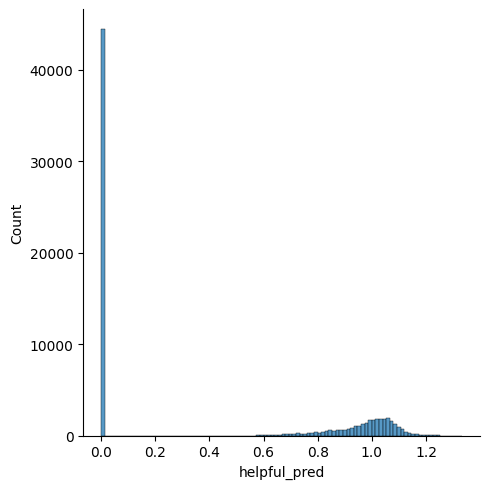

In [245]:
import seaborn as sns
sns.displot(predictions, x="helpful_pred", bins=100)

In [246]:
predictions.to_parquet('/content/drive/MyDrive/Code + Data/Final Model Predictions/aspect_predictions.parquet')